**Imports and Setup**
- This section imports all required libraries for image processing, evaluation, and visualization.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorthief import ColorThief
from skimage import color
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_fscore_support,
    accuracy_score
)

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

**Load CSV with Labels**
- We load the ground truth undertone labels from undertone_labels.csv, and clean the strings to ensure consistency (e.g., lowercase, stripped).

In [2]:
# Load and normalize labels
labels_df = pd.read_csv("undertone_labels.csv")
labels_df["ground_truth_undertone"] = labels_df["ground_truth_undertone"].str.strip().str.lower()

**Image Processing + Rule-Based Prediction**
For each image:
- We apply skin masking using HSV color space.
- Extract dominant RGB color using ColorThief.
- Convert RGB to CIELAB color space.
- Classify the undertone based on CIELAB a* and b* values using a rule-based method.

In [3]:
actuals = []
predictions = []
lab_points = []

for index, row in labels_df.iterrows():
    img_name = row["image_name"]
    true_label = row["ground_truth_undertone"]
    img_path = os.path.join("images", img_name)

    image = cv2.imread(img_path)
    if image is None:
        continue

    # Skin segmentation using HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_skin = (0, 20, 70)
    upper_skin = (20, 255, 255)
    mask = cv2.inRange(image_hsv, lower_skin, upper_skin)
    skin = cv2.bitwise_and(image, image, mask=mask)

    # Save temporary image
    temp_path = "temp.jpg"
    cv2.imwrite(temp_path, skin)

    try:
        color_thief = ColorThief(temp_path)
        dominant_rgb = color_thief.get_color(quality=1)
    except:
        continue

    # Convert to CIELAB
    rgb_array = np.array(dominant_rgb) / 255.0
    lab = color.rgb2lab(rgb_array.reshape((1, 1, 3)))
    _, a, b = lab[0, 0]

    # Rule-based logic
    if a > 15 and b < 10:
        pred = "cool"
    elif b > 15 and a < 10:
        pred = "warm"
    elif 10 <= a <= 15 and 10 <= b <= 15:
        pred = "neutral"
    else:
        pred = "unclassified"


    actuals.append(true_label)
    predictions.append(pred)
    lab_points.append((a, b, true_label, pred))


**Evaluation Metrics**
- We calculate binary confusion matrices for each undertone class individually. This shows how well each class was predicted against all others.

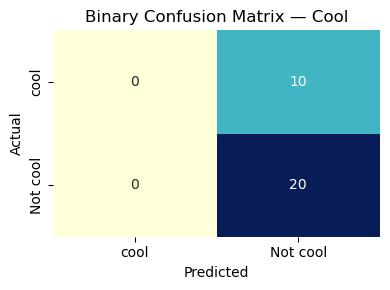

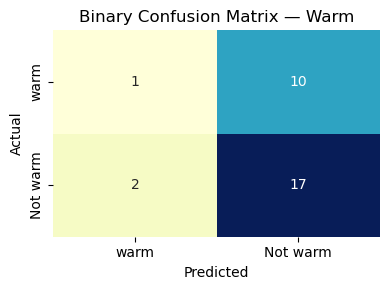

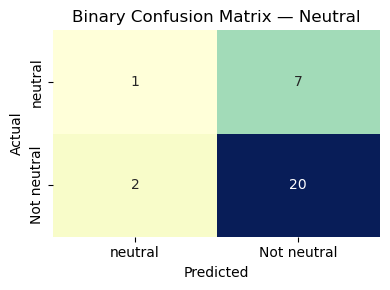

In [4]:
# Normalize predictions
actuals = [a.strip().lower() for a in actuals]
predictions = [p.strip().lower() for p in predictions]

labels = ["cool", "warm", "neutral"]

# Print class-wise confusion matrices
for target_class in labels:
    binary_actuals = [1 if label == target_class else 0 for label in actuals]
    binary_preds = [1 if label == target_class else 0 for label in predictions]

    if sum(binary_actuals) == 0 and sum(binary_preds) == 0:
        print(f"Skipping {target_class} — no data.")
        continue

    cm = confusion_matrix(binary_actuals, binary_preds, labels=[1, 0])

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False,
                xticklabels=[f"{target_class}", f"Not {target_class}"],
                yticklabels=[f"{target_class}", f"Not {target_class}"])
    plt.title(f"Binary Confusion Matrix — {target_class.capitalize()}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

**Precision, Recall, F1 Bar Plot**
- A bar chart summarizes the classifier’s performance for each undertone class using precision, recall, and F1-score metrics. Overall accuracy is also printed.

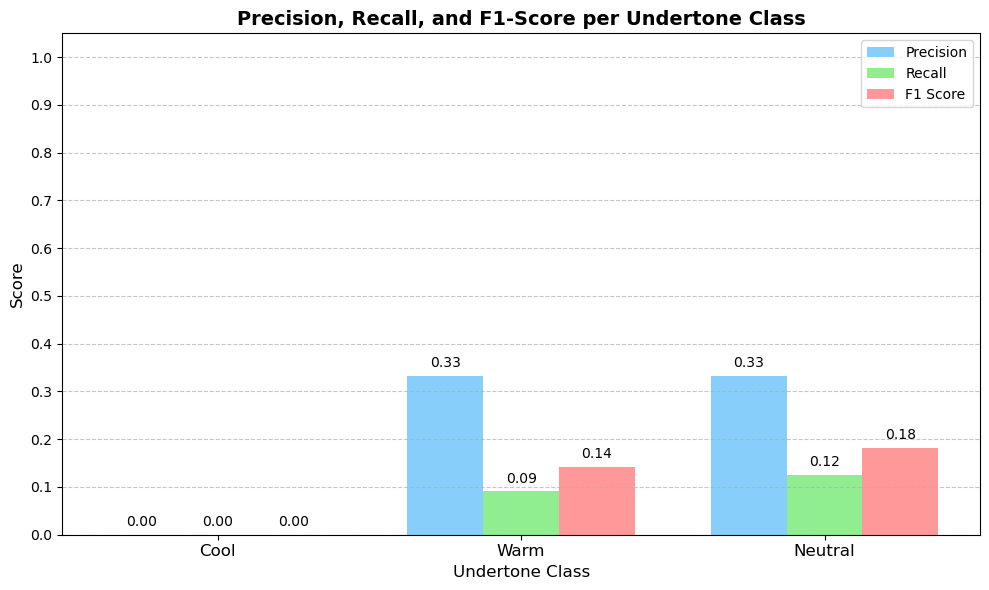


Overall Accuracy: 6.67%


In [5]:
precision, recall, f1, support = precision_recall_fscore_support(
    actuals, predictions, labels=labels, zero_division=0
)
accuracy = accuracy_score(actuals, predictions)

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
bar1 = plt.bar(x - width, precision, width=width, label='Precision', color='#87CEFA')
bar2 = plt.bar(x, recall, width=width, label='Recall', color='#90EE90')
bar3 = plt.bar(x + width, f1, width=width, label='F1 Score', color='#FF9999')

# Annotate bars
for bars in [bar1, bar2, bar3]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f"{height:.2f}",
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 4),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=10)

plt.xticks(x, [l.capitalize() for l in labels], fontsize=12)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1.05)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Undertone Class", fontsize=12)
plt.title("Precision, Recall, and F1-Score per Undertone Class", fontsize=14, weight='bold')
plt.legend(loc="upper right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nOverall Accuracy:", f"{accuracy * 100:.2f}%")

**CIELAB a/b Visualization**

This scatter plot shows each image's CIELAB a*/b* values:

- Color of point = actual label
- Shape of point = predicted label

This helps visualize how well the rule-based logic separates undertones in color space.

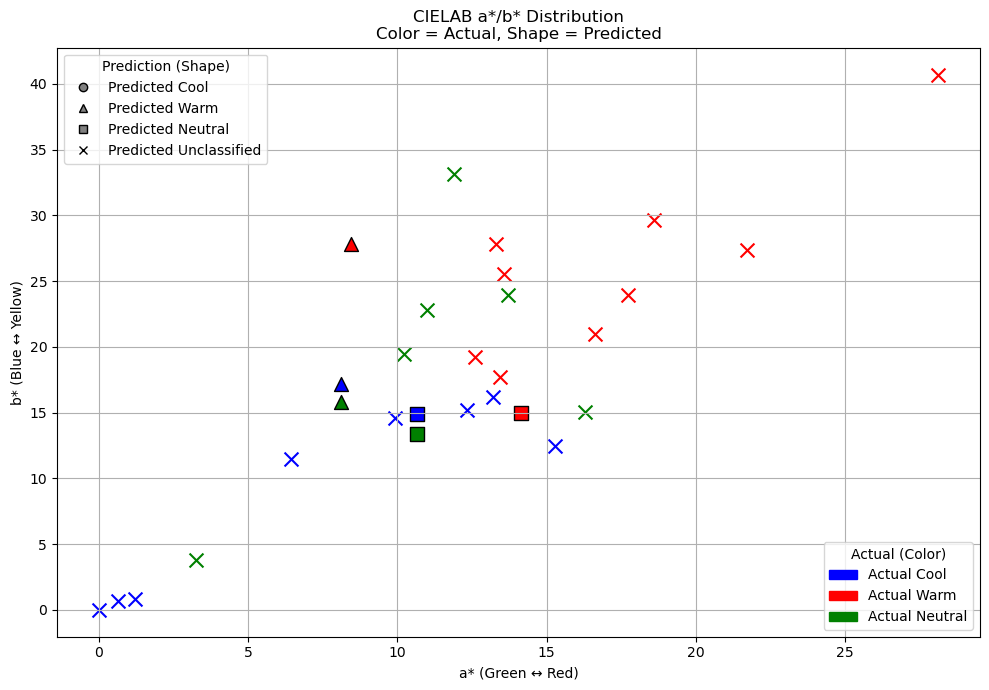

In [6]:
def marker(pred):
    return 'o' if pred == 'cool' else '^' if pred == 'warm' else 's' if pred == 'neutral' else 'x'

def safe_scatter(a, b, pred, color, label):
    m = marker(pred)
    if m == 'x':
        plt.scatter(a, b, c=color, marker=m, s=100, label=label)
    else:
        plt.scatter(a, b, c=color, marker=m, edgecolor='black', s=100, label=label)

cool = [(a, b, p) for (a, b, a_lbl, p) in lab_points if a_lbl == "cool"]
warm = [(a, b, p) for (a, b, a_lbl, p) in lab_points if a_lbl == "warm"]
neutral = [(a, b, p) for (a, b, a_lbl, p) in lab_points if a_lbl == "neutral"]

plt.figure(figsize=(10, 7))
for a, b, p in cool:
    safe_scatter(a, b, p, 'blue', 'Cool')
for a, b, p in warm:
    safe_scatter(a, b, p, 'red', 'Warm')
for a, b, p in neutral:
    safe_scatter(a, b, p, 'green', 'Neutral')

plt.xlabel("a* (Green ↔ Red)")
plt.ylabel("b* (Blue ↔ Yellow)")
plt.title("CIELAB a*/b* Distribution\nColor = Actual, Shape = Predicted")
plt.grid(True)

import matplotlib.patches as mpatches
legend_shapes = [
    plt.Line2D([0], [0], marker='o', color='w', label='Predicted Cool', markerfacecolor='gray', markeredgecolor='black'),
    plt.Line2D([0], [0], marker='^', color='w', label='Predicted Warm', markerfacecolor='gray', markeredgecolor='black'),
    plt.Line2D([0], [0], marker='s', color='w', label='Predicted Neutral', markerfacecolor='gray', markeredgecolor='black'),
    plt.Line2D([0], [0], marker='x', color='black', label='Predicted Unclassified', linestyle='None'),
]
legend_colors = [
    mpatches.Patch(color='blue', label='Actual Cool'),
    mpatches.Patch(color='red', label='Actual Warm'),
    mpatches.Patch(color='green', label='Actual Neutral'),
]
first_legend = plt.legend(handles=legend_shapes, title="Prediction (Shape)", loc='upper left')
plt.gca().add_artist(first_legend)
plt.legend(handles=legend_colors, title="Actual (Color)", loc='lower right')
plt.tight_layout()
plt.show()
